<h1 style="text-align: center;">Facial Expression Detection</h1>

Dataset can be downloaded [here](https://www.kaggle.com/competitions/challenges-in-representation-learning-facial-expression-recognition-challenge/data)

In [224]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from sklearn.utils import shuffle
from PIL import Image
from datetime import datetime
import math

In [225]:
def get_image(idx):
    img = data.loc[idx, "pixels"]
    img = np.array(img.split(), dtype=np.uint8).reshape(48,48)
    return img

In [226]:
## creating data generator
def data_generator(data, indices, transform=None, batch_size=128):
    n_batches = math.ceil(len(indices)/batch_size)

    for i in range(n_batches):
        batch_idxs = indices[i*batch_size:(i+1)*batch_size]
        X_batch = []
        y_batch = np.zeros(len(batch_idxs), dtype=np.uint8)
        for i in range(len(batch_idxs)):
            idx = batch_idxs[i]
            img = data.loc[idx, "pixels"]
            img = np.array(img.split(), dtype=np.uint8).reshape(48,48)
            img = Image.fromarray(img)
            if transform:
                img = transform(img)
                
            target = data.loc[idx, "emotion"]

            X_batch.append(img)
            y_batch[i] = target

        yield torch.stack(X_batch), torch.from_numpy(y_batch)

In [227]:
import os

In [228]:
## getting labels
# (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)
labels = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral"
}

data_folder = "x__data"
data = pd.read_csv(os.path.join(data_folder, "train.csv"))

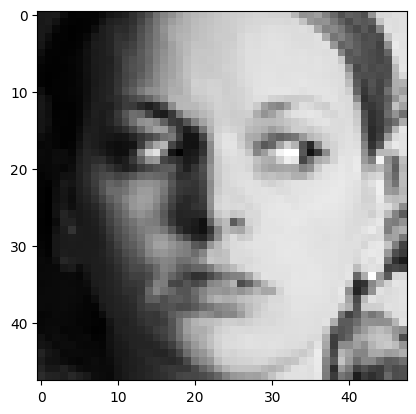

In [229]:
## visualizing single image
rand_idx = np.random.choice(len(data))
img = get_image(rand_idx)
plt.imshow(img, cmap="gray")
plt.show()

In [230]:
## dividing the indices
random_state = 235
validation_size = 0.3
n = len(data)
validation_end_idx = math.floor(validation_size * n)

new_idxs = shuffle(list(data.index), random_state=random_state)
validation_idxs, train_idxs = new_idxs[:validation_end_idx], new_idxs[validation_end_idx:]

In [231]:
## creating data generators
batch_size = 128

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor()
])
validation_transforms = transforms.ToTensor()

train_generator = lambda : data_generator(data, train_idxs, train_transforms, batch_size)
validation_generator = lambda : data_generator(data, validation_idxs, validation_transforms, batch_size)

In [232]:
# np.vstack(data.loc[[0,1,2,3], "pixels"].apply(lambda x: np.array(x.split())).values).reshape(-1, 48, 48).shape

In [233]:
## creating model
class CNN(nn.Module):
    def __init__(self, output_size):
        super(CNN, self).__init__()

        self.K = output_size

        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(6*6*128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            # nn.Linear(64, 32),
            # nn.ReLU(),
            nn.Linear(64, self.K)
        )

    def forward(self, X):
        out = self.cnn(X)
        out = self.fc(out.view(out.shape[0], -1))
        return out

In [234]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [235]:
model = CNN(len(labels))
model.to(device)

CNN(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=4608, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=7, bias=True)
  )
)

In [236]:
## creating criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [237]:
## creating batch gradient descent function
def batch_gd(model, criterion, optimizer, train_loader, validation_loader, epochs=20):
    train_losses = []
    validation_losses = []

    for it in range(epochs):
        t0 = datetime.now()
        epoch_losses = []
        model.train()
        for inputs, targets in train_loader():
            optimizer.zero_grad()
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.item())
            
        train_losses.append(np.mean(epoch_losses))

        
        epoch_losses = []
        model.eval()
        for inputs, targets in validation_loader():
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            epoch_losses.append(loss.item())
            
        validation_losses.append(np.mean(epoch_losses))

        dt = datetime.now() - t0

        print(f"Epoch {it+1}/{epochs}, Train Loss: {train_losses[it]}, Validation Loss: {validation_losses[it]}, Duration: {dt}")

    return train_losses, validation_losses

In [238]:
train_losses, validation_losses = batch_gd(model,
                                           criterion,
                                           optimizer,
                                           train_generator,
                                           validation_generator,
                                           epochs=20
                                          )

Epoch 1/20, Train Loss: 1.7800350883339024, Validation Loss: 1.770391634281944, Duration: 0:01:40.406964
Epoch 2/20, Train Loss: 1.624026458286032, Validation Loss: 1.6182516076985527, Duration: 0:01:53.909340
Epoch 3/20, Train Loss: 1.5012117216858683, Validation Loss: 1.5485254385892082, Duration: 0:01:46.134574
Epoch 4/20, Train Loss: 1.4217230149344364, Validation Loss: 1.424833646591972, Duration: 0:02:27.849424
Epoch 5/20, Train Loss: 1.347093010038326, Validation Loss: 1.367024945862153, Duration: 0:02:28.599712
Epoch 6/20, Train Loss: 1.3038081330589102, Validation Loss: 1.801540981320774, Duration: 0:02:03.899237
Epoch 7/20, Train Loss: 1.3139165911375532, Validation Loss: 1.3010417222976685, Duration: 0:01:57.773062
Epoch 8/20, Train Loss: 1.2163845271437983, Validation Loss: 1.3030586698476005, Duration: 0:02:20.723871
Epoch 9/20, Train Loss: 1.184274589439524, Validation Loss: 1.2573429854477154, Duration: 0:02:26.981117
Epoch 10/20, Train Loss: 1.150814344876599, Validatio

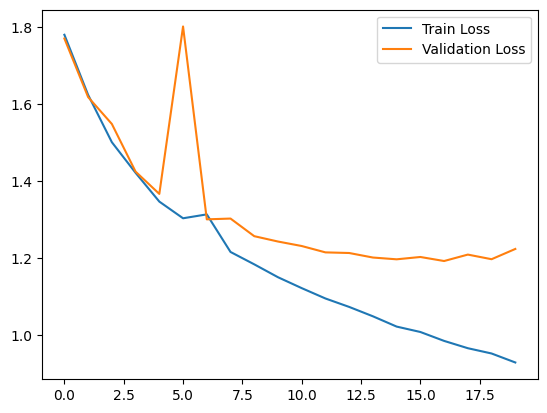

In [239]:
plt.plot(train_losses, label="Train Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.legend()
plt.show()

In [240]:
## getting accuracy
with torch.no_grad():
    model.eval()
    n_correct = 0
    count = 0
    for inputs, targets in train_generator():
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        n_correct += sum(preds == targets).item()
        count += len(targets)

    train_acc = n_correct/count
    
    n_correct = 0
    count = 0
    for inputs, targets in validation_generator():
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        n_correct += sum(preds == targets).item()
        count += len(targets)

    validation_acc = n_correct/count

print(f"Train Accuracy: {train_acc}, Validation Accuracy: {validation_acc}")

Train Accuracy: 0.6780116435288849, Validation Accuracy: 0.5520204366000929
